In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [4]:
# Generate synthetic time series data
data = np.sin(np.linspace(0, 100, 1000))  # Example sine wave data
df = pd.DataFrame(data, columns=['value'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create sequences for multi-step forecasting
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 15, 10
X, y = create_sequences(scaled_data, n_steps_in, n_steps_out)

print(X.shape)
print(y.shape)
print(X[10])
print(y[10])

(976, 15, 1)
(976, 10, 1)
[[0.9210057 ]
 [0.94585314]
 [0.96623684]
 [0.98195273]
 [0.99284348]
 [0.99880004]
 [0.99976278]
 [0.99572206]
 [0.98671834]
 [0.97284176]
 [0.95423124]
 [0.93107311]
 [0.90359922]
 [0.87208463]
 [0.83684486]]
[[0.7982327 ]
 [0.75663474]
 [0.71246744]
 [0.66617298]
 [0.61821486]
 [0.56907321]
 [0.51924002]
 [0.46921421]
 [0.41949661]
 [0.37058498]]


In [3]:
print(len(data))

1000


In [5]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
print(n_steps_out)

10


In [6]:
# Reshape data for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train the model
history = model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
31/31 [==============================] - 2s 7ms/step - loss: 0.2989
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.1310
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0931
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 7/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 8/200
31/31 [==============================] - 0s 6ms/step - loss: 3.2462e-04
Epoch 9/200
31/31 [==============================] - 0s 6ms/step - loss: 2.0304e-04
Epoch 10/200
31/31 [==============================] - 0s 6ms/step - loss: 1.6672e-04
Epoch 11/200
31/31 [==============================] - 0s 7ms/step - loss: 1.3108e-04
Epoch 12/200
31/31 [==============================] - 0s 8ms/step - loss: 1.0849e-04
Epoch 13/200
31/3

In [7]:
print(history)

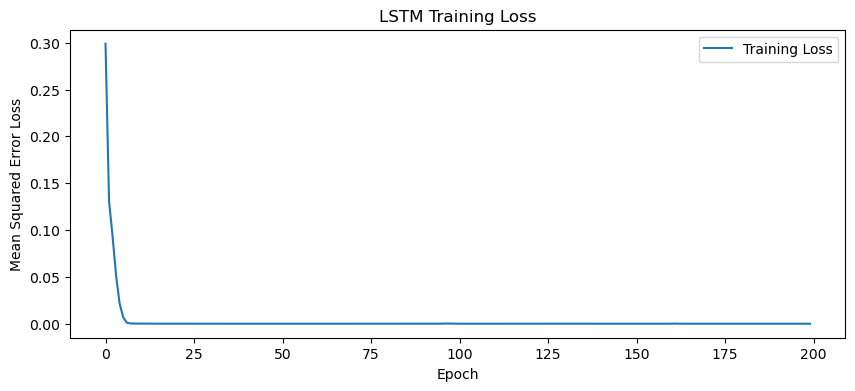

In [8]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [10]:
# Make predictions
predictions = model.predict(X)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)

# Display predictions
print(predictions)

31/31 [==============================] - 0s 3ms/step
[[ 0.9898603   0.99158955  0.9764503  ...  0.79705584  0.73418117
   0.666275  ]
 [ 0.99182343  0.98121023  0.9574437  ...  0.7321516   0.6617421
   0.5861883 ]
 [ 0.9859761   0.9641683   0.93096304 ...  0.66220665  0.5842693
   0.50264263]
 ...
 [-1.0000371  -1.0015025  -0.994235   ... -0.8056262  -0.7432037
  -0.67102915]
 [-1.0008397  -0.99157715 -0.97362643 ... -0.74093044 -0.6713385
  -0.5927182 ]
 [-0.99139947 -0.97227806 -0.9441757  ... -0.6693319  -0.59351593
  -0.5090364 ]]


In [11]:
from sklearn.metrics import mean_squared_error

# Test case 1: Check the shape of the predictions
assert predictions.shape == (X.shape[0], n_steps_out), "Shape mismatch in predictions"

# Test case 2: Check the range of the predictions
assert np.all(predictions >= -1.01) and np.all(predictions <= 1.01), "Predictions are out of expected range"

# Test case 3: Calculate and print the Mean Squared Error
mse = mean_squared_error(scaler.inverse_transform(y.reshape(-1, n_steps_out)), predictions)
print(f"Mean Squared Error: {mse}")

# Test case 4: Check if the model is not overfitting by comparing training and validation loss
history = model.fit(X, y, epochs=200, validation_split=0.2, verbose=1)
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
assert abs(train_loss - val_loss) < 0.01, "Model might be overfitting"

Mean Squared Error: 5.933182430419904e-05
Epoch 1/200
25/25 [==============================] - 1s 27ms/step - loss: 7.7045e-06 - val_loss: 2.7801e-06
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 3.6173e-06 - val_loss: 3.5093e-06
Epoch 3/200
25/25 [==============================] - 0s 9ms/step - loss: 3.9007e-06 - val_loss: 2.3181e-06
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 2.7059e-06 - val_loss: 5.6734e-06
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: 3.2047e-06 - val_loss: 2.1892e-06
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 4.4226e-06 - val_loss: 2.5570e-06
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 1.0557e-05 - val_loss: 3.1441e-06
Epoch 8/200
25/25 [==============================] - 0s 8ms/step - loss: 5.9651e-06 - val_loss: 1.9484e-05
Epoch 9/200
25/25 [==============================] - 0s 8ms/step - loss: 1.0774e-05 - val_loss: 1.192

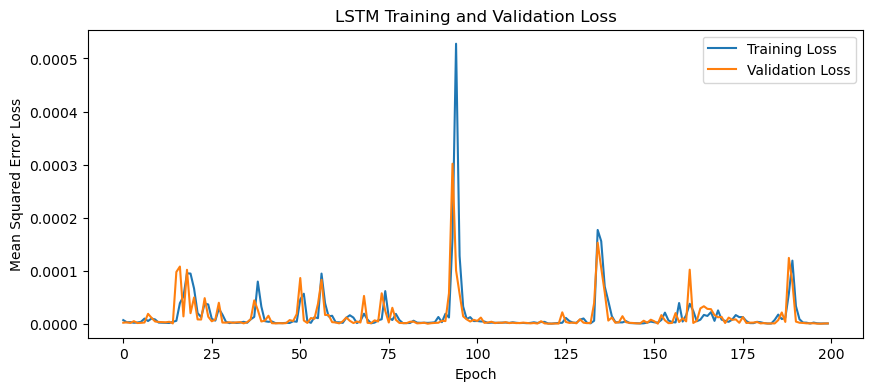

In [13]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Predictions
y_pred = model.predict(X)
print(y.shape)
y_test = y[:, :, 0]
# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Complete the Evaluate the model section with R-squared value printing
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

31/31 [==============================] - 0s 7ms/step
(976, 10, 1)
Mean Squared Error (MSE): 1.4446146905603178e-06
Root Mean Squared Error (RMSE): 0.0012019212497332418
Mean Absolute Error (MAE): 0.0009872467614262946
R-squared (R²): 0.999988455892928


In [27]:
print(y_pred.shape)

(976, 10)
